In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from chronos import Chronos2Pipeline

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]

## Data Quality

In [3]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


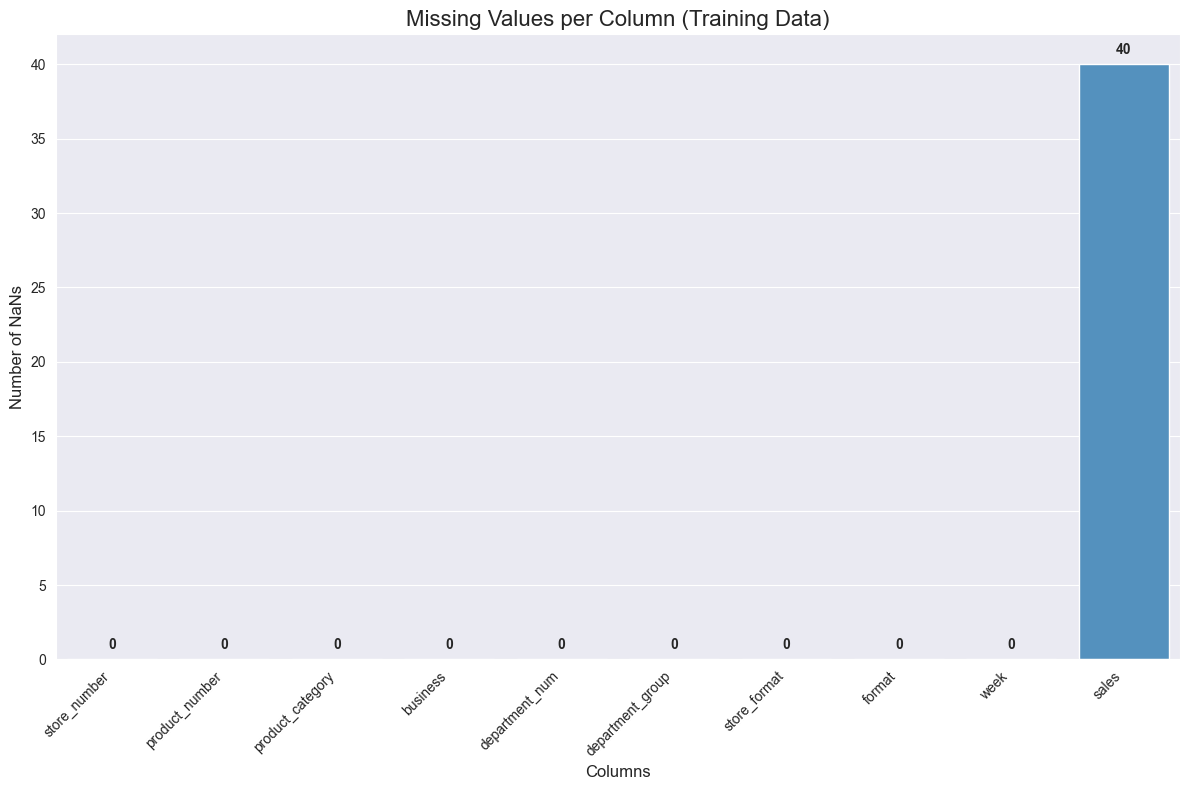

In [4]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(12, 8))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color="#4293D0")

plt.title("Missing Values per Column (Training Data)", fontsize=16)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('missing_values.png')
plt.show()

## Preprocessing

In [5]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
format                       int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int64
dtype: object

In [6]:
## Exploratory Data Analysis

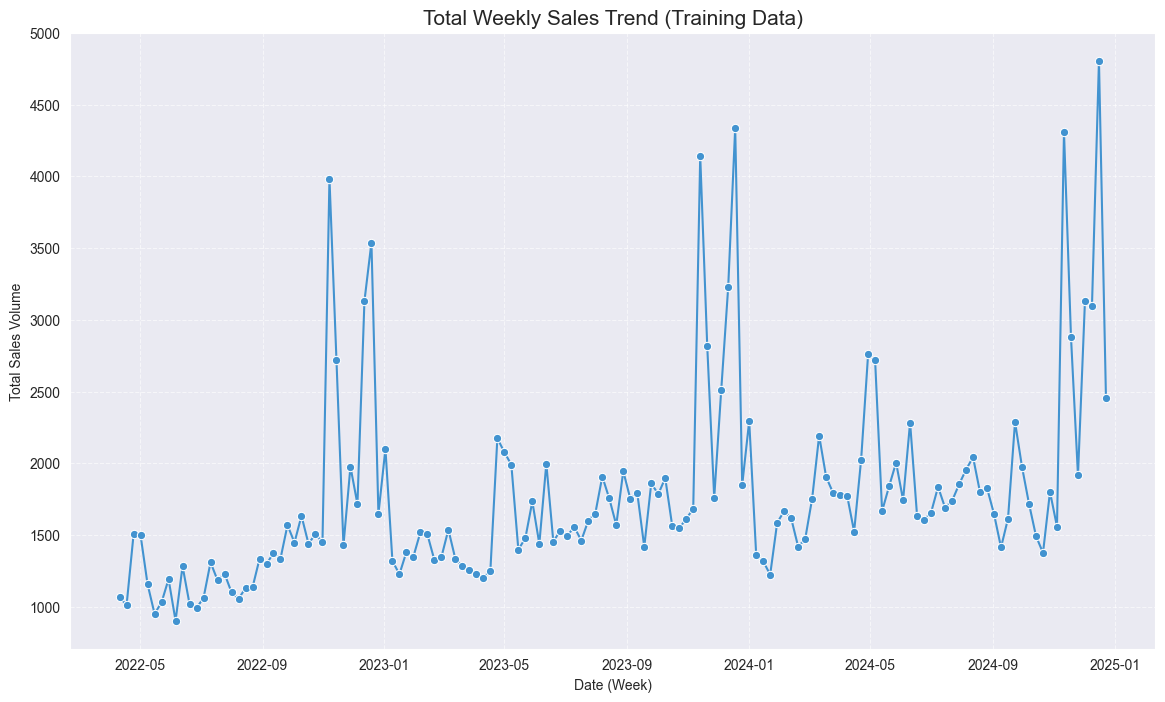

In [7]:
plt.figure(figsize=(14, 8))
weekly_sales = X_train_preprocessed.groupby('week')['sales'].sum().reset_index()
sns.lineplot(data=weekly_sales, x='week', y='sales', marker='o', color="#4293D0")
plt.title('Total Weekly Sales Trend (Training Data)', fontsize=15)
plt.xlabel('Date (Week)')
plt.ylabel('Total Sales Volume')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('time_series.png')
plt.show()

product_number (297 values): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ... [np.int64(292), np.int64(293), np.int64(294), np.int64(295), np.int64(296)]
product_category (111 values): [np.int64(20318), np.int64(20319), np.int64(30103), np.int64(30104), np.int64(40209), np.int64(40214), np.int64(40215), np.int64(40217), np.int64(50910), np.int64(90214)] ... [np.int64(540101), np.int64(540301), np.int64(580003), np.int64(580007), np.int64(590001)]
business (47 values): [np.int64(203), np.int64(301), np.int64(402), np.int64(509), np.int64(902), np.int64(905), np.int64(1404), np.int64(1405), np.int64(1406), np.int64(1706)] ... [np.int64(5400), np.int64(5401), np.int64(5403), np.int64(5800), np.int64(5900)]
department_num (26 values): [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(9), np.int64(14), np.int64(17), np.int64(20), np.int64(23), np.int64(24)] ... [np.int64(47), np.int64(53), np.i

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_43937/297846064.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


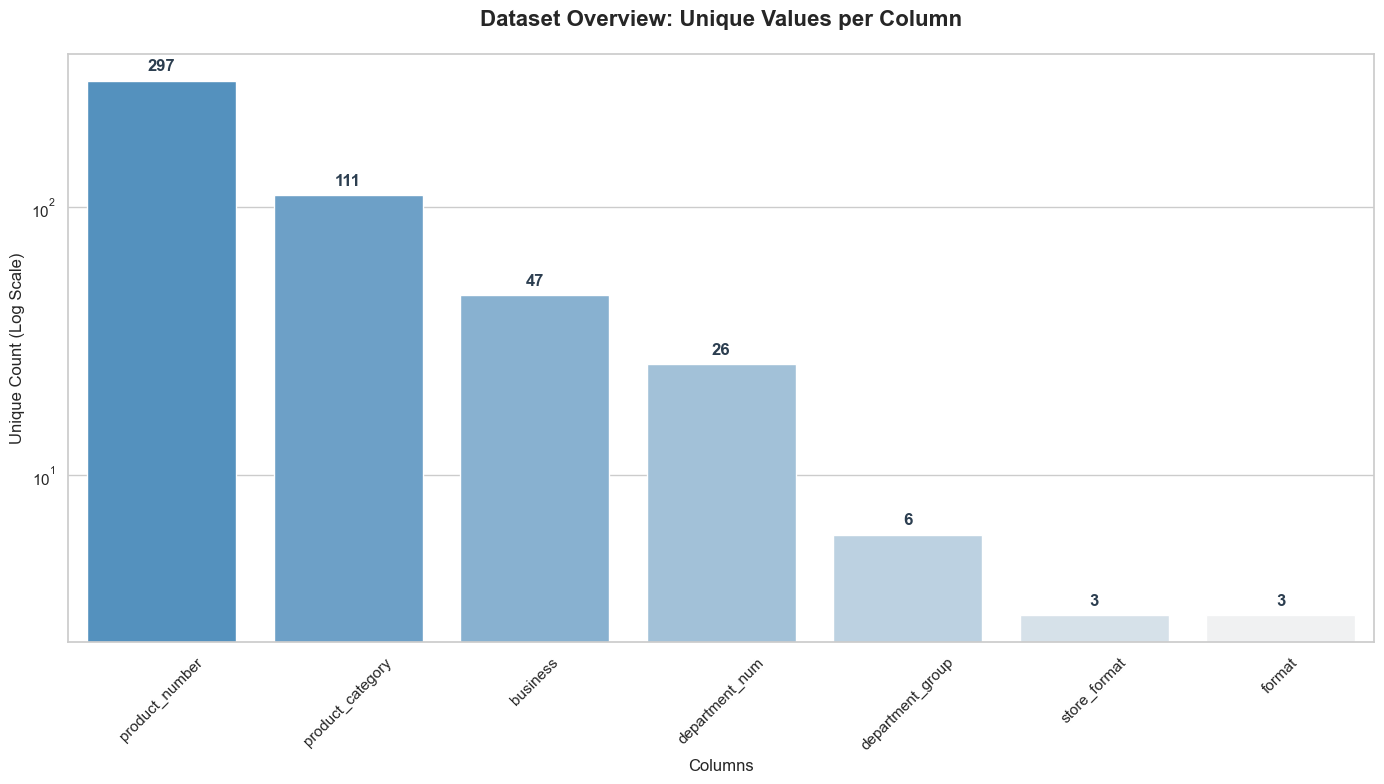

In [8]:
def display_dataset_summary(df):
    # Define the columns of interest
    cols = [
        'product_number', 'product_category', 'business',
        'department_num', 'department_group', 'store_format', 'format'
    ]

    # Calculate unique counts and retrieve actual values
    summary_data = []
    for col in cols:
        unique_vals = sorted(df[col].unique())
        num_unique = len(unique_vals)
        summary_data.append({'Dimension': col, 'Unique Count': num_unique})

        # Print actual values (truncated if there are more than 20)
        if num_unique <= 20:
            print(f"{col} ({num_unique} values): {unique_vals}")
        else:
            print(f"{col} ({num_unique} values): {unique_vals[:10]} ... {unique_vals[-5:]}")

    # Handle the 'week' column separately for the timeline
    if 'week' in df.columns:
        print(f"\nTimeline (week):")
        print(f"  Min Date: {df['week'].min()}")
        print(f"  Max Date: {df['week'].max()}")

    # Prepare the data for plotting
    summary_df = pd.DataFrame(summary_data).sort_values('Unique Count', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # Create a gradient palette based on your specific blue tone (#4293D0)
    custom_palette = sns.light_palette("#4293D0", n_colors=len(summary_df), reverse=True)

    # Create the barplot using the custom blue palette
    ax = sns.barplot(
        x='Dimension',
        y='Unique Count',
        data=summary_df,
        palette=custom_palette
    )

    # Apply log scale for the y-axis (useful for comparing small vs large counts)
    plt.yscale('log')

    # Add data labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=12, fontweight='bold', color='#2c3e50')

    # Formatting the chart
    plt.title('Dataset Overview: Unique Values per Column', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Unique Count (Log Scale)', fontsize=12)
    plt.xlabel('Columns', fontsize=12)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

display_dataset_summary(X_train_preprocessed)

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_43937/175787391.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


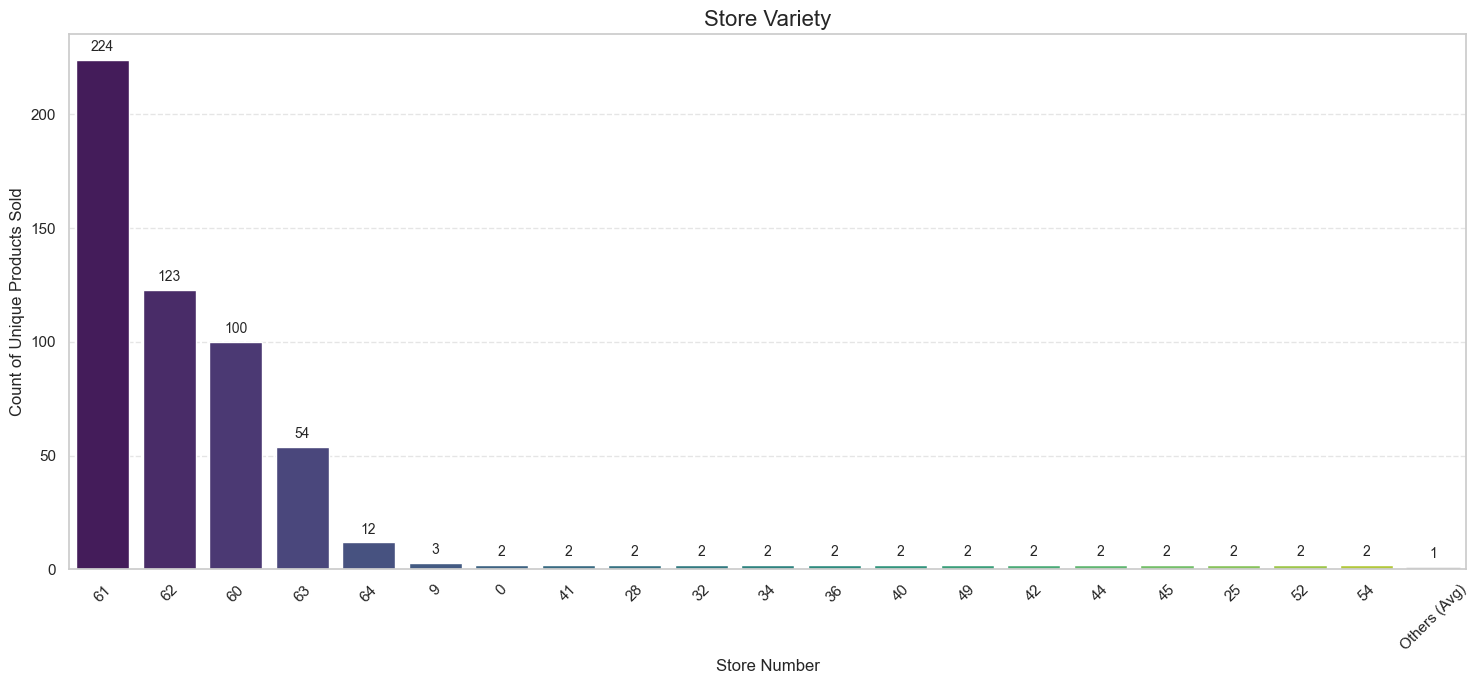

In [9]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others (Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(15, 7))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_43937/2061478277.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


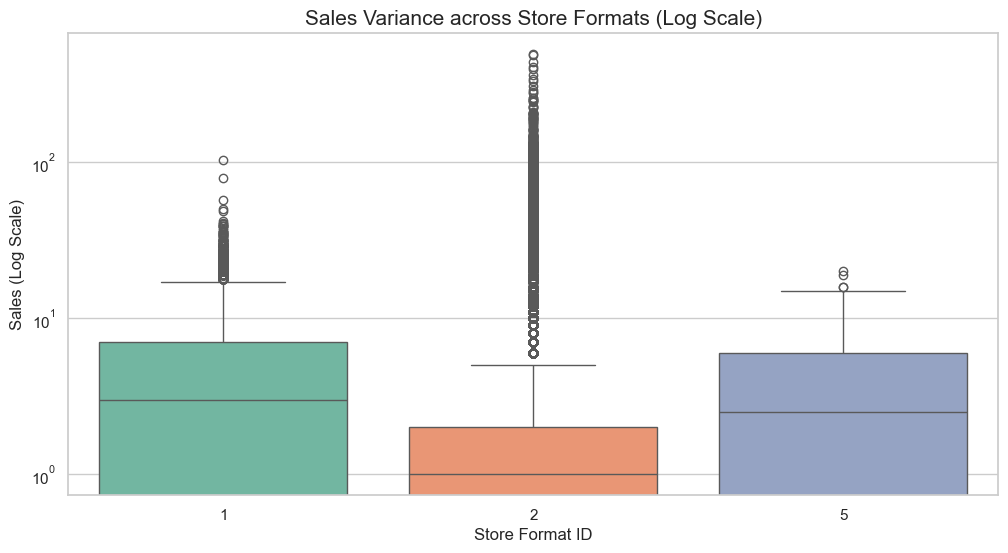

In [10]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.show()

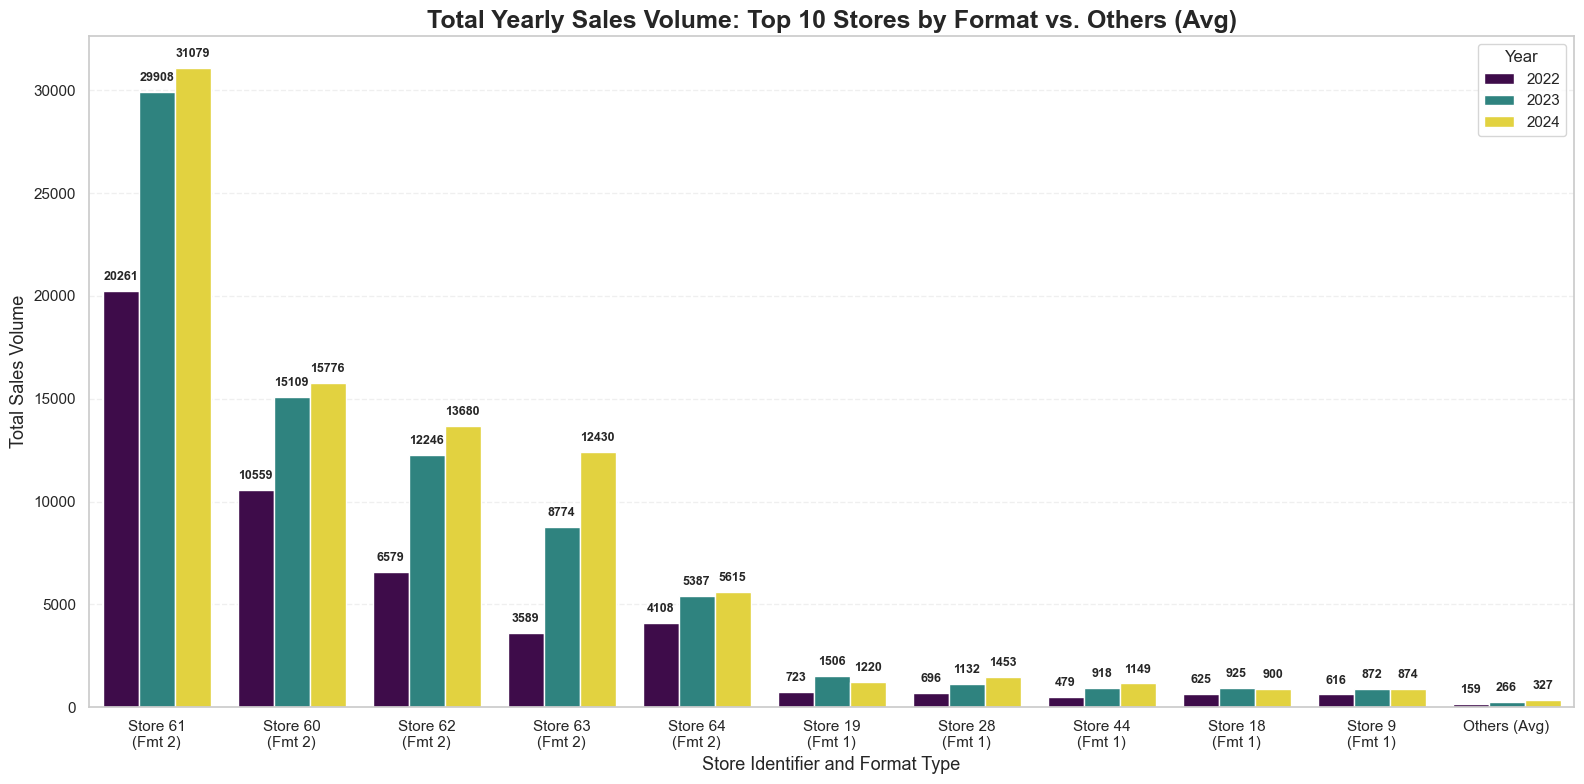

In [11]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

plt.figure(figsize=(16, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette='viridis',
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', fontsize=18, fontweight='bold')
plt.xlabel('Store Identifier and Format Type', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

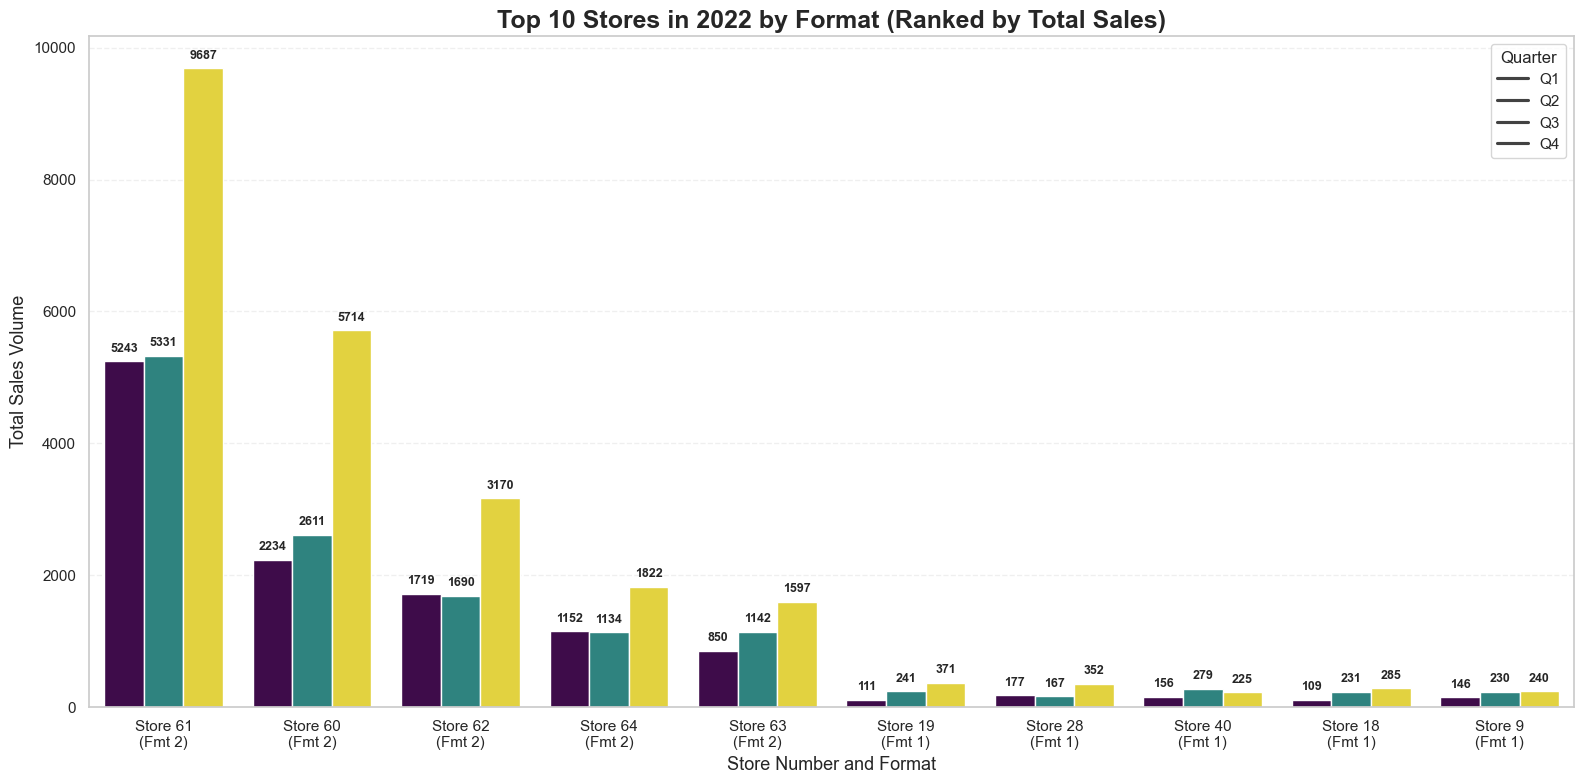

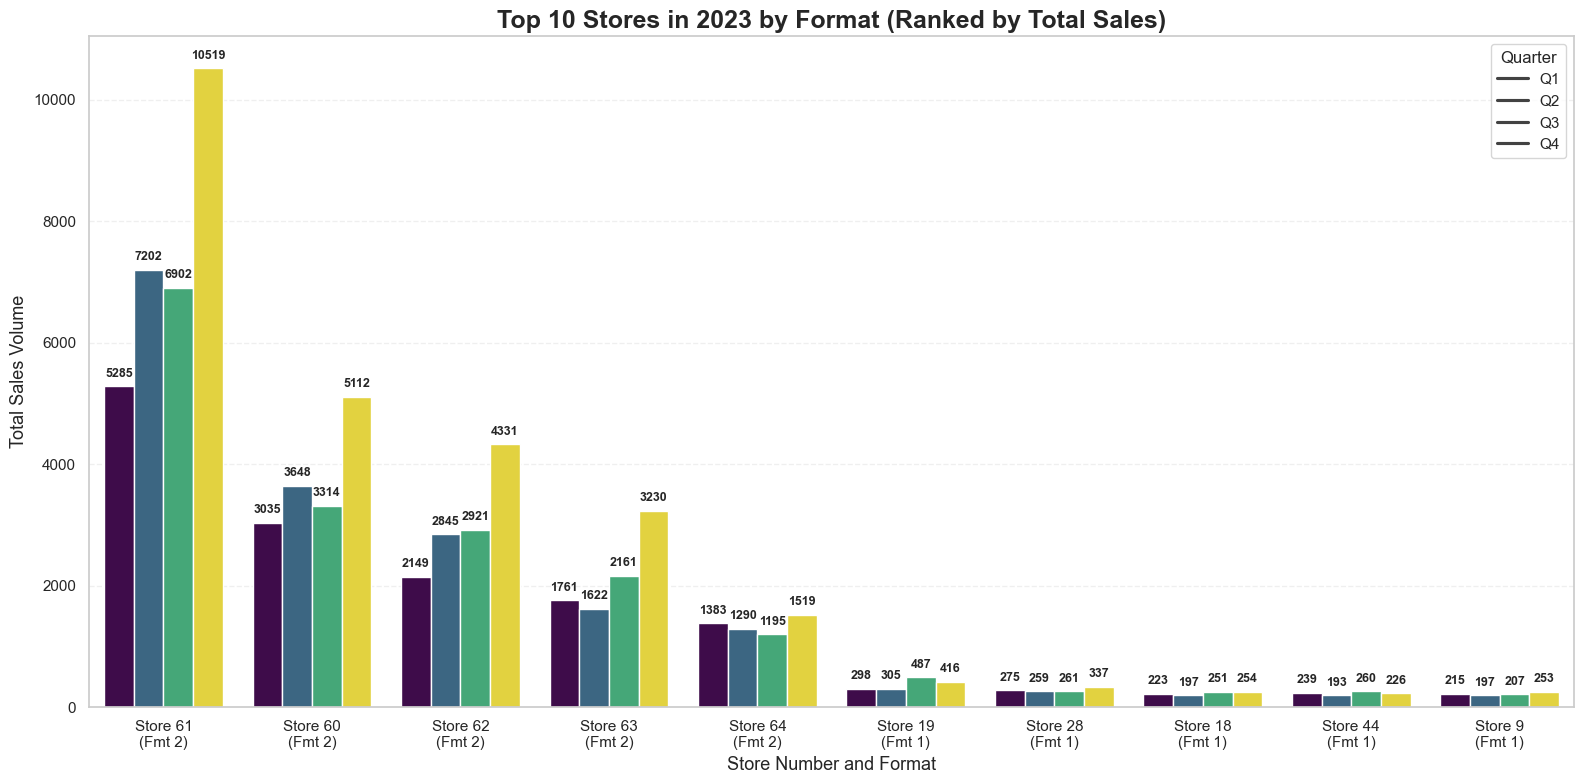

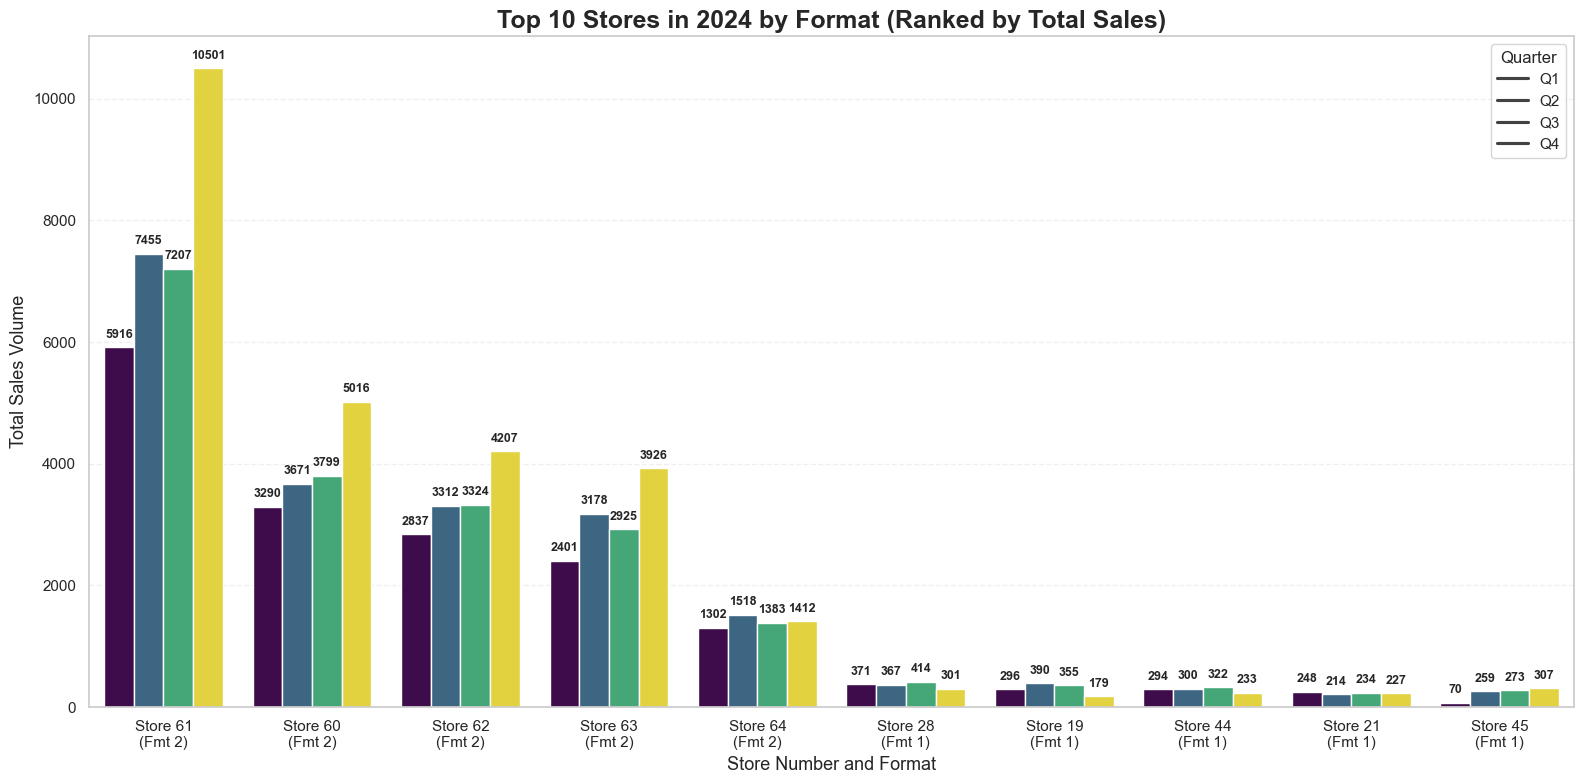

In [12]:
# Ensure time features and mapping exist
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

# Create a unique mapping of store numbers to their formats
store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

# Aggregation
yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

# Iterate through years
years = sorted(yearly_store_stats['year'].unique())

for year in years:
    # Filter for the specific year
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    # Identify top 10 stores for this specific year
    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    # Merge format info and filter for top 10
    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    # Create a combined label for the X-axis: "Store ID (Format)"
    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    # 4. Plotting
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    plt.show()

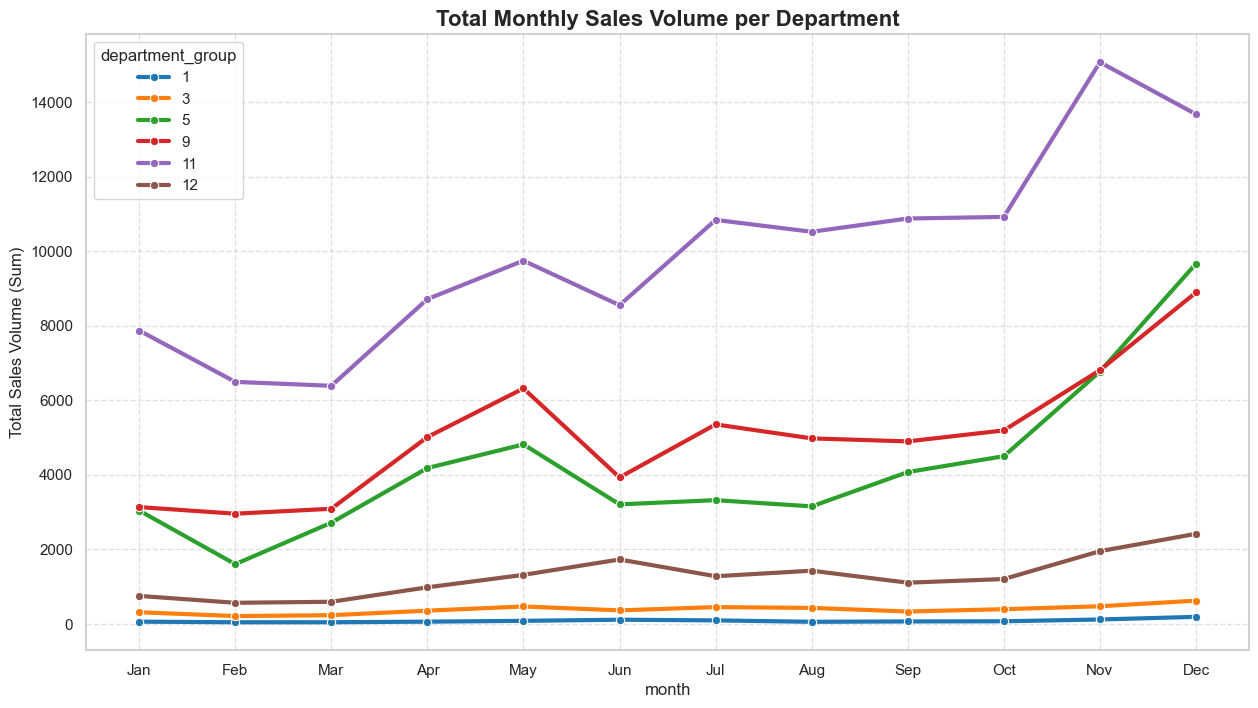

In [13]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

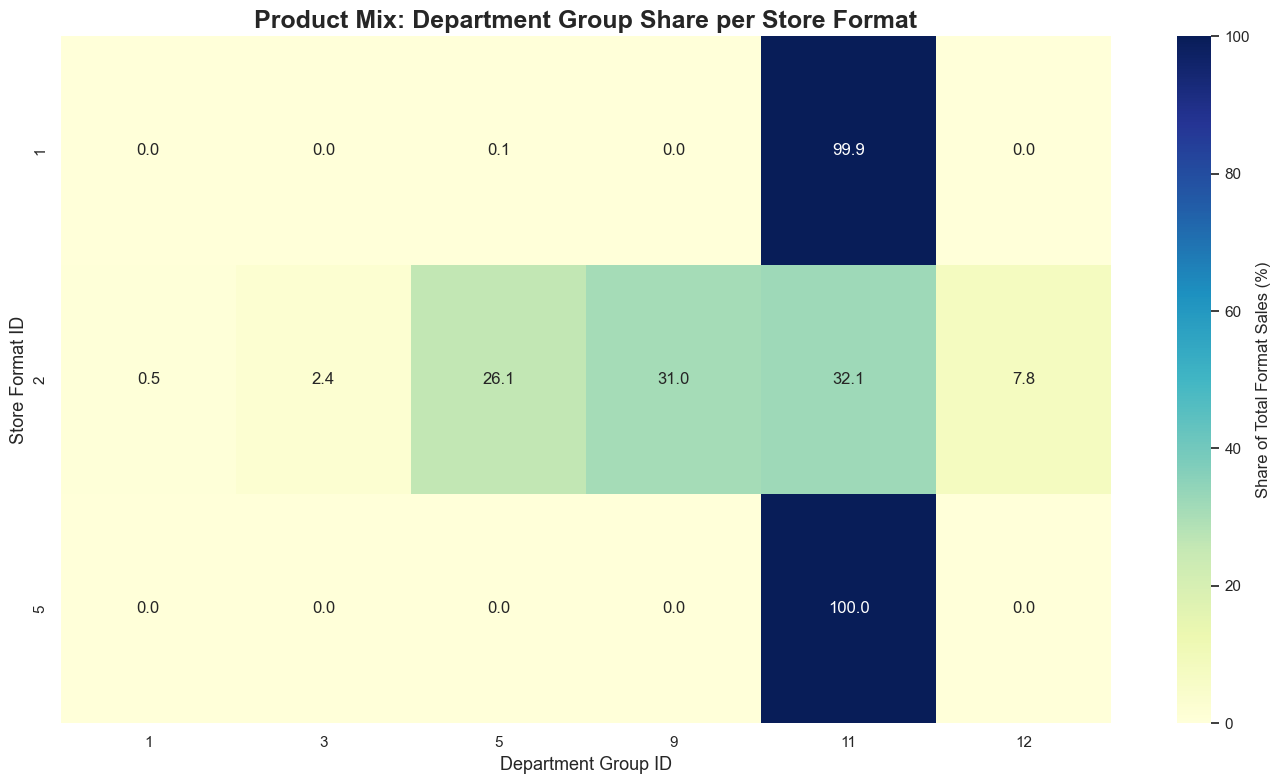

In [14]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.show()

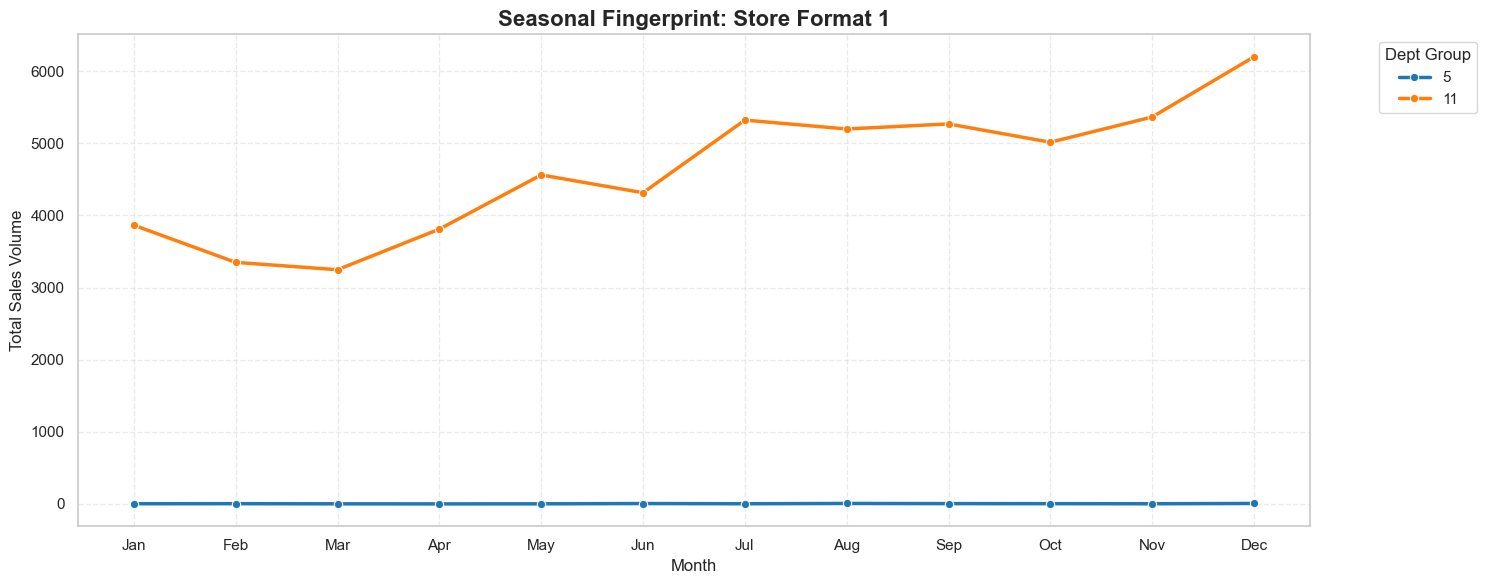

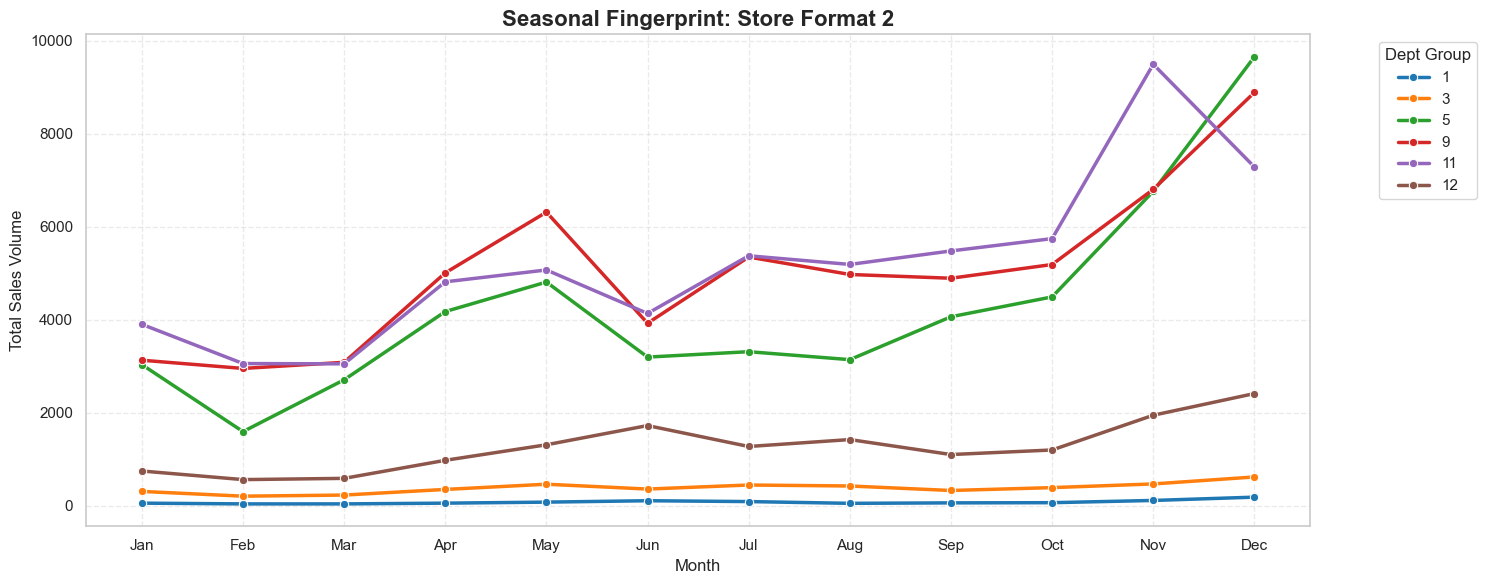

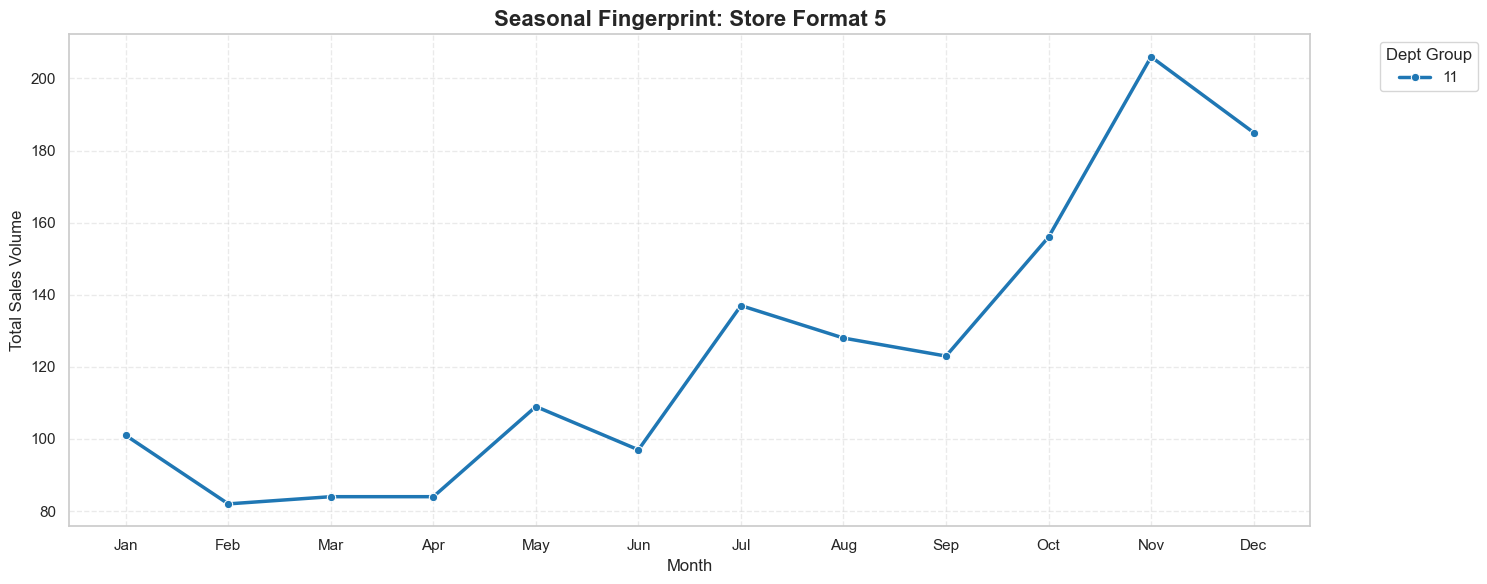

In [15]:
# Identify all unique store formats
unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    # Filter data for the specific format
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]

    # Aggregate sales by department and month for this format
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    # Visualization
    plt.figure(figsize=(15, 6))
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette="tab10"
    )

    plt.title(f'Seasonal Fingerprint: Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume')
    plt.xlabel('Month')
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Feature Engineering

In [16]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,format,week,sales,...,rolling_std_4_wks,rolling_mean_12_wks,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,prod_store_share,perf_vs_store,yoy_growth
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,...,74276.000000,69484.000000,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,7.607300e+04,65151.000000,5.391000e+04
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,189.398998,2023-08-17 11:59:59.999999744,2.964413,...,1.737603,2.873261,0.956172,2.842173,2.705913,2.965433,0.002152,8.359471e+05,1.022792,6.902806e+05
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,13.000000,2022-04-11 00:00:00,0.000000,...,0.000000,0.000000,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000e+00,0.000000,0.000000e+00
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,216.000000,2022-12-12 00:00:00,0.000000,...,0.500000,0.583333,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000e+00,0.000000,0.000000e+00
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,216.000000,2023-08-17 12:00:00,1.000000,...,0.957427,1.083333,0.934171,2.287719,1.266667,1.795745,0.000000,2.066116e-03,0.253472,6.363636e-01
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,216.000000,2024-04-22 00:00:00,2.000000,...,1.732051,2.083333,1.333332,2.946237,2.986395,4.728571,0.405465,9.174312e-03,0.784053,1.899998e+01
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,521.000000,2024-12-23 00:00:00,494.000000,...,203.021345,190.666667,3.000000,26.333333,36.833333,15.558685,4.890349,2.500000e+08,302.548612,1.110000e+08
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,73.948953,NaN,10.595799,...,4.489321,8.546508,0.661086,2.032836,3.611927,2.322635,0.725240,3.953342e+06,4.468564,2.603973e+06


In [17]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Data Preparation for Model Training

In [18]:
date_col = data_loader.get_date_col()
target_col = data_loader.get_target_col()

X_train_engineered = X_train_engineered.sort_values(by=date_col)

X_train_chronos = X_train_engineered.copy()

X_train_full = X_train_engineered.drop(columns=[target_col, "week", "quarter", "week_of_year", "month"])
y_train_full = X_train_engineered[target_col]

# Define Categorical Data
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format', 'format'
]

for col in categorical_features:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')

horizon = 15
x_fold_cv = 3

## Chronos-2 Model Performance

In [ ]:
X_train_chronos['id'] = X_train_chronos['store_number'].astype(str) + '_' + X_train_chronos['product_number'].astype(str)

results = {}
final_models = {}

all_dates = sorted(X_train_chronos[date_col].unique())
cv_rmses = []

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="mps")

useful_covariates = [
    'id', date_col,
    'week_sin', 'week_cos',
    'dept_seasonal_avg',
    'velocity',
    'yoy_growth'
]

print(f"\nStarting Cross-Validation for Chronos-2")

for i in range(x_fold_cv):
    test_start_idx = len(all_dates) - (horizon * (i + 1))
    test_end_idx = test_start_idx + horizon

    cutoff_date = all_dates[test_start_idx]
    end_date = all_dates[test_end_idx - 1]

    context_df = X_train_chronos[X_train_chronos[date_col] < cutoff_date].copy()
    context_df = context_df.groupby('id').tail(52)

    ground_truth = X_train_chronos[(X_train_chronos[date_col] >= cutoff_date) &
                                   (X_train_chronos[date_col] <= end_date)].copy()
    future_df = ground_truth.drop(columns=[target_col]).copy()

    future_df = ground_truth[useful_covariates].copy()

    # Generate Forecasts
    pred_df = pipeline.predict_df(
        context_df,
        future_df=future_df,
        prediction_length=horizon,
        quantile_levels=[0.5], # Median for point forecast
        id_column="id",
        timestamp_column=date_col,
        target=target_col,
        batch_size=64
    )

    comparison = ground_truth.merge(pred_df[['id', date_col, '0.5']], on=['id', date_col])
    window_rmse = root_mean_squared_error(comparison[target_col], comparison['0.5'])
    cv_rmses.append(window_rmse)

    print(f"Fold {i + 1}: Cutoff {cutoff_date.date()} | RMSE: {window_rmse:.4f}")

    if i == 0:  # i=0 is the most recent window in your n_windows loop
        final_models['Chronos-2'] = pipeline
        # Optional: store the final validation comparison for plotting
        X_val_chronos_final = ground_truth
        y_val_chronos_final = ground_truth[target_col]

# Final Evaluation
average_rmse_chronos = np.mean(cv_rmses)
results['Chronos-2'] = average_rmse_chronos
print(f"\nAverage CV RMSE for Chronos-2: {average_rmse_chronos:.4f}")


Starting Cross-Validation for Chronos-2


## Boost Model Performance

In [ ]:
rows_per_week = X_train_engineered.groupby(date_col).size().iloc[0]
horizon_rows = int(rows_per_week * horizon)

tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)

# Cross-Validation Loop
models_to_test = ['CatBoost', 'XGBoost', 'LightGBM']

for model_name in models_to_test:
    fold_errors = []
    print(f"\nStarting Cross-Validation for {model_name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        val_dates = X_train_engineered.iloc[val_idx][date_col]

        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_name == 'CatBoost':
            m = CatBoostRegressor(
                iterations=2000, learning_rate=0.05, depth=6,
                loss_function='RMSE', random_seed=42, verbose=False,
                early_stopping_rounds=50
            )
            m.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))

        elif model_name == 'XGBoost':
            m = xgb.XGBRegressor(
                n_estimators=1000, learning_rate=0.05, max_depth=6,
                objective='reg:squarederror', enable_categorical=True,
                tree_method='hist', random_state=42, verbosity=0
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        elif model_name == 'LightGBM':
            m = lgb.LGBMRegressor(
                n_estimators=1000, learning_rate=0.05,
                objective='regression', metric='rmse',
                random_state=42, verbose=-1
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(50)])

        # Calculate RMSE for this fold
        fold_rmse = root_mean_squared_error(y_va, m.predict(X_va))
        fold_errors.append(fold_rmse)

        print(f"Fold {fold + 1}: Cutoff {val_dates.min().date()} | RMSE: {fold_rmse:.4f}")

        # Store the model and data from the latest fold
        if fold == tscv.n_splits - 1:
            final_models[model_name] = m
            X_val_final, y_val_final, val_dates_final = X_va, y_va, val_dates

    results[model_name] = np.mean(fold_errors)
    print(f"\nAverage CV RMSE for {model_name}: {results[model_name]:.4f}")

# Final Results
winner_name = min(results, key=results.get)

cat_model = final_models.get('CatBoost')
xgb_model = final_models.get('XGBoost')
lgb_model = final_models.get('LightGBM')

## Results

In [ ]:
df_leaderboard = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
df_leaderboard = df_leaderboard.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(12, 6))
winner_overall = df_leaderboard.iloc[0]['Model']
colors = ['#27ae60' if model == winner_overall else '#34495e' for model in df_leaderboard['Model']]

ax = sns.barplot(
    data=df_leaderboard,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Bar Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Final Model Leaderboard: 3-Fold Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=13)
plt.ylabel('Model Name', fontsize=13)
plt.xlim(0, df_leaderboard['RMSE'].max() * 1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('model_leaderboard.png')
plt.show()

print(f"Overall Champion: {winner_overall}")

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 8)
    l2_reg = trial.suggest_float('l2_reg', 1e-2, 10.0, log=True)

    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)
    cv_scores = []
    fold_best_ntrees = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if winner_name == 'XGBoost':
            model = xgb.XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500,
                tree_method='hist', enable_categorical=True,
                random_state=42, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], early_stopping_rounds=30, verbose=False)
            fold_best_ntrees.append(model.best_iteration)

        elif winner_name == 'CatBoost':
            model = CatBoostRegressor(
                learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_reg,
                iterations=1500, early_stopping_rounds=30,
                random_seed=42, verbose=False
            )
            model.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))
            fold_best_ntrees.append(model.get_best_iteration())

        elif winner_name == 'LightGBM':
            model = lgb.LGBMRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500, random_state=42, verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(30)])
            fold_best_ntrees.append(model.best_iteration_)

        score = root_mean_squared_error(y_va, model.predict(X_va))
        cv_scores.append(score)

        trial.report(np.mean(cv_scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    avg_ntree = int(np.mean(fold_best_ntrees))
    trial.set_user_attr("best_ntree", avg_ntree)

    return np.mean(cv_scores)


study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=42),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)

study.optimize(objective, n_trials=50)

print(f"Best Score (RMSE): {study.best_value:.4f}")
print(f"Best Parameter: {study.best_params}")


In [ ]:
best_params = study.best_params.copy()
best_ntree = study.best_trial.user_attrs["best_ntree"]

l2_val = best_params.pop('l2_reg', None)

if winner_name == 'XGBoost':
    if l2_val: best_params['reg_lambda'] = l2_val
    final_model = xgb.XGBRegressor(
        **best_params,
        n_estimators=best_ntree,
        enable_categorical=True,
        random_state=42
    )
elif winner_name == 'CatBoost':
    if l2_val: best_params['l2_leaf_reg'] = l2_val
    final_model = CatBoostRegressor(
        **best_params,
        iterations=best_ntree,
        random_seed=42,
        verbose=False,
        cat_features=categorical_features
    )
elif winner_name == 'LightGBM':
    if l2_val: best_params['reg_lambda'] = l2_val
    final_model = lgb.LGBMRegressor(
        **best_params,
        n_estimators=best_ntree,
        random_state=42
    )

final_model.fit(X_train_full, y_train_full)

print(f"Final training complete. Model uses the top {best_ntree} iterations found by Optuna.")

In [ ]:
feature_names = X_train_full.columns

if winner_name == 'CatBoost':
    importances = final_model.get_feature_importance()
    color = '#27ae60'
elif winner_name == 'XGBoost':
    importances = final_model.feature_importances_
    color = '#2980b9'
elif winner_name == 'LightGBM':
    importances = final_model.feature_importances_
    color = '#f39c12'

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Normalize importances of the features
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=color)

plt.title(f'Feature Importance: {winner_name} (Best Performing Final Model)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Importance Percentage (%)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Test Data

In [ ]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_train_full.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if winner_name != 'CatBoost':
    for col in categorical_features:
        # Cast to category
        X_test_predict[col] = X_test_predict[col].astype('category')
        # Ensure the test set has the EXACT same category mapping as the train set
        X_test_predict[col] = X_test_predict[col].cat.set_categories(X_train_full[col].cat.categories)

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'week']].copy()
df_results['sales'] = test_predictions

df_results_preprocessed = data_loader.preprocessing(df_results)

output_path = f'final_sales_predictions_{winner_name}.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

In [ ]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_train_full.index],
    'sales': y_train_full
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1).rename(columns={'sales': 'sales'})

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(16, 7))

# Plot Historical Sales
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#2c3e50', linewidth=2.5, alpha=0.8)

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['sales'],
         label=f'Future Forecast ({winner_name})', color='#e67e22',
         linestyle='--', linewidth=3, marker='o', markersize=4)

# Split Line
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({winner_name})", fontsize=18, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='-', alpha=0.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sales_forecast_connected.png')
plt.show()

## Trends in Forecast Data

In [ ]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('Strategic Q1 Benchmark: 2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

In [ ]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(16, 9))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()